In [1]:
import matplotlib.pyplot as plt
import xarray as xr
from PIL import Image
import numpy as np
import cartopy.crs as ccrs
import cartopy.feature as cfeature
from cartopy.mpl.ticker import LongitudeFormatter, LatitudeFormatter
import warnings
warnings.filterwarnings('ignore')
lonmin, lonmax = -180, 180
latmin, latmax = -60, 90
extents = [lonmin, lonmax, latmin, latmax]

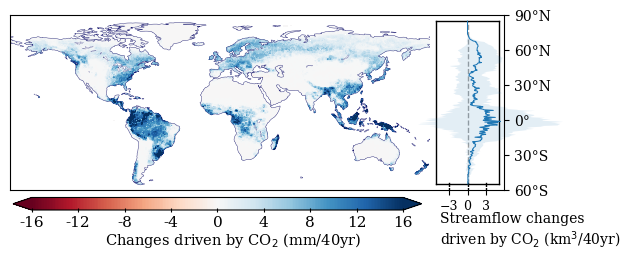

In [2]:
# Calculating the area of each grid
def cal_area():
    lon = [-180+0.5*i for i in range(721)]
    lat = [-90 + 0.5 * i for i in range(361)]
    R = 6371.393
    data = np.zeros((360, 720))
    for i in range(720):
        for j in range(360):
            area = (np.pi/180) * (R**2) * abs(np.sin(lat[j]/180*np.pi) - np.sin(lat[j+1]/180*np.pi)) * abs(lon[i]-lon[i+1])
            data[j, i] = area
    return data

# Plotting Figure 1a and 1b
def Figure_1ab():
    data = xr.open_dataset(r"dataset\streamflow_CO2_tend.nc")
    co2 = data.CO2.data[:]*40 # Trends multiplied by 40 years

    d = cal_area()
    lat_runoff = np.zeros((14, 360))
    for i in range(14):
        # unit conversion
        d_here = co2[i, :] * d / 1000000
        lat_runoff[i, :] = np.nansum(d_here, axis=1)

    # Plotting b
    fig = plt.figure(figsize=(6.1, 2.5))
    ax = fig.add_axes([0.58, 0.25, 0.35, 0.7])
    ax.patch.set_alpha(0)
    # Calculate the median and standard deviation
    MED = np.median(lat_runoff, axis=0)
    STD = np.std(lat_runoff, axis=0)
    ax.tick_params(top=False, bottom=True,
                   left=False, right=True,
                   labeltop=False, labelbottom=True,
                   labelleft=False, labelright=True)
    # Plots the results for the main area, with the other areas extremely close or at 0.
    ax.plot(MED[70:-10], data.lat.data[70:-10], c='#1f77b4', linewidth=0.75, label='Median', zorder=10)
    ax.fill_betweenx(data.lat.data, MED + STD, MED - STD, alpha=0.12, linewidth=0, color='#1f77b4',
                     label='1 std', zorder=10)
    ax.yaxis.set_major_formatter(LatitudeFormatter())
    ax.set_ylim([-60, 90])
    ax.set_xlim([-17, 17])

    # Draw the borders and key lines of figure b.
    ax.plot([0, 0], [-55, 85], '--', color='gray', zorder=0, linewidth=1.0, alpha=0.75)
    ax.plot([-5, -5], [-55, 85], '-', color='k', zorder=0, linewidth=1, alpha=1)
    ax.plot([5, 5], [-55, 85], '-', color='k', zorder=0, linewidth=1, alpha=1)
    ax.plot([-5, 5], [-55, -55], '-', color='k', zorder=0, linewidth=1, alpha=1)
    ax.plot([-5, 5], [85, 85], '-', color='k', zorder=0, linewidth=1, alpha=1)
    ax.plot([-3, -3], [-60, -54], '-', color='k', zorder=0, linewidth=1, alpha=1)
    ax.plot([-0, -0], [-60, -54], '-', color='k', zorder=0, linewidth=1, alpha=1)
    ax.plot([3, 3], [-60, -54], '-', color='k', zorder=0, linewidth=1, alpha=1)
    ax.plot([-5, 5], [-57.5, -57.5], '-', color='w', zorder=0, linewidth=0.75, alpha=1)
    ax.spines['bottom'].set_linewidth(0)
    ax.spines['top'].set_linewidth(0)
    ax.spines['left'].set_linewidth(0)
    ax.spines['right'].set_linewidth(0)
    plt.xticks([-3, 0, 3], family='serif', fontsize=9)
    plt.yticks([], family='serif')
    fig.text(0.71, 0.01, "Streamflow changes \ndriven by CO$_2$ (km$^3$/40yr)",
                                  fontfamily='serif', va='bottom', ha='left')


    # Plotting a
    change = data.CO2.data[:14,:]*40
    change = np.nanmedian(change, axis=0)
    proj = ccrs.PlateCarree()
    ax = fig.add_axes([-0.05, 0.25, 0.8, 0.7], projection=proj)
    ax.patch.set_alpha(0)
    colorK = plt.get_cmap('RdBu')(np.linspace(0, 1, 240))
    colorneed = colorK[[i for i in range(240)]]
    im = ax.contourf(
        data.lon.data, data.lat.data, change,
        levels=[-16 + 16 / 120 * i for i in range(241)],
        colors=colorneed, extend='both',
        alpha=1, zorder=10)

    ax.coastlines(resolution='110m', lw=0.3, color='#191970', zorder=12)
    ax.add_feature(cfeature.LAKES, facecolor='white', zorder=12, lw=0.15, edgecolor='#191970')
    ax.set_extent(extents, crs=proj)
    ax.axis('off')
    ax.tick_params(labelsize='small')
    plt.xticks(family='serif')
    plt.yticks(family='serif')

    # Plotting colorbar
    ax4 = fig.add_axes([0.01, 0.17, 0.67, 0.05])
    cbar = fig.colorbar(im, cax=ax4, orientation='horizontal')
    cbar.ax.tick_params(bottom=True, tickdir='inout', pad=2)
    cbar.set_ticks([-16 + i * 4 for i in range(9)])
    cbar.set_ticklabels([int(-16 + i * 4) for i in range(9)], fontsize=11, family='serif')

    fig.text(0.37, 0.05, 'Changes driven by CO$_2$ (mm/40yr)', fontsize=10.5, fontfamily='serif',
             va='center', ha='center')

    ax = fig.add_axes([0.005, 0.25, 0.81, 0.7])
    ax.patch.set_alpha(0)
    ax.set_yticks(np.arange(-90, 90 + 30, 30))
    ax.yaxis.set_major_formatter(LatitudeFormatter())
    ax.set_ylim([-60, 90])
    ax.yaxis.tick_right()
    plt.xticks([])
    plt.yticks(family='serif')

    fig.patch.set_alpha(0)

    plt.tight_layout()
    plt.rcParams['savefig.dpi'] = 3000
    plt.show()

Figure_1ab()

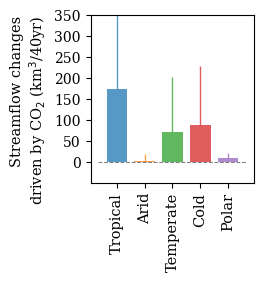

In [3]:
def Figure_1c():
    data = xr.open_dataset(r"dataset\streamflow_CO2_tend.nc")
    con = xr.open_dataset(r"dataset\Beck_KG_5_classifications.nc")
    con = con.data[:]
    co2 = data.CO2.data[:]*40

    d = cal_area()
    lat_runoff = np.zeros((14, 5))
    for i in range(14):
        d_here = co2[i, :] * d / 1000000
        for j in range(5):
            lat_runoff[i, j] = np.nansum(d_here[con==j+1])

    fig = plt.figure(figsize=(2.5, 2.6))
    ax = fig.add_subplot(111)
    ax.plot([0.3, 5.7], [0, 0], 'k--', zorder=0, alpha=0.5, linewidth=0.75)
    ax.plot([-10, -10], [0, 0], 'k-', zorder=0, alpha=1, linewidth=0.75, label='1 std')
    plt.bar(x=[1, 2, 3, 4, 5], height=np.median(lat_runoff, axis=0), width=0.75,
            alpha=0.75, color=['#1f77b4', '#ff7f0e', '#2ca02c', '#d62728', '#9467bd'],
            error_kw={'linewidth': 0.75})
    y = np.median(lat_runoff, axis=0)
    std = np.std(lat_runoff, axis=0)
    color = ['#1f77b4', '#ff7f0e', '#2ca02c', '#d62728', '#9467bd']
    for i in [0, 1, 2, 3, 4]:
        ax.errorbar(x=[i+1], y=y[i], yerr=[[0], [std[i]]], color=color[i], linewidth=1, alpha=0.75)

    plt.xlim([0.05, 5.95])
    plt.ylim([-50, 350])
    plt.xticks([1, 2, 3, 4, 5], ['Tropical', 'Arid', 'Temperate', 'Cold', 'Polar'],
               rotation=90,
               family='serif', fontsize=10.5)
    plt.yticks([0, 50, 100, 150, 200, 250, 300, 350], family='serif')
    plt.ylabel('Streamflow changes\ndriven by CO$_2$ (km$^3$/40yr)', family='serif',
               fontsize=10.5, loc='top')
    fig.patch.set_alpha(0)
    plt.tight_layout()
    plt.subplots_adjust(
        top=0.995,
        bottom=0.35,
        left=0.335,
        right=0.99,
        hspace=0.2,
        wspace=0.2)
    plt.rcParams['savefig.dpi'] = 3000
    plt.show()

Figure_1c()

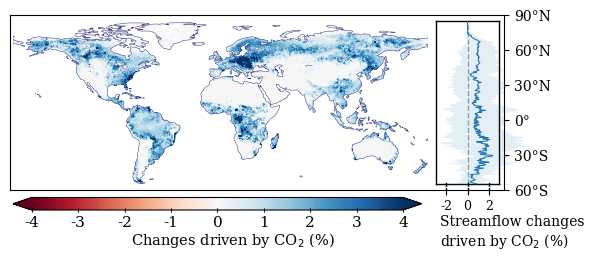

In [4]:
def Figure_1de():
    data = xr.open_dataset(r"dataset\streamflow_CO2_tend.nc")
    data2 = xr.open_dataset(r"dataset\streamflow_simulation.nc")
    co2 = data.CO2.data[:]*40
    s3 = data2.S3.data[:]
    d = cal_area()
    lat_runoff = np.zeros((14, 360))
    for i in range(14):
        d_here = co2[i, :] * d / 1000000
        ds3_here = s3[i, :] * d / 1000000
        lat_runoff[i, :] = np.nansum(d_here, axis=1)/np.nansum(ds3_here, axis=1)
    lat_runoff[np.isnan(lat_runoff)] = 0
    fig = plt.figure(figsize=(6.1, 2.5))
    ax = fig.add_axes([0.58, 0.25, 0.35, 0.7])
    ax.patch.set_alpha(0)
    MED = np.median(lat_runoff, axis=0)
    STD = np.std(lat_runoff, axis=0)
    ax.tick_params(top=False, bottom=True,
                   left=False, right=True,
                   labeltop=False, labelbottom=True,
                   labelleft=False, labelright=True)
    ax.plot(MED[70:-10], data.lat.data[70:-10], c='#1f77b4', linewidth=0.75, label='Median', zorder=10)
    ax.fill_betweenx(data.lat.data, MED + STD, MED - STD, alpha=0.12, linewidth=0, color='#1f77b4',
                     label='1 std', zorder=10)
    ax.yaxis.set_major_formatter(LatitudeFormatter())
    ax.set_ylim([-60, 90])
    l1 = 0.1
    ax.set_xlim([-l1, l1])
    ax.plot([0, 0], [-55, 85], '--', color='gray', zorder=0, linewidth=1.0, alpha=0.75)
    sk = 5/17*l1
    sk2 = 0.02
    ax.plot([-sk, -sk], [-55, 85], '-', color='k', zorder=0, linewidth=1, alpha=1)
    ax.plot([sk, sk], [-55, 85], '-', color='k', zorder=0, linewidth=1, alpha=1)
    ax.plot([-sk, sk], [-55, -55], '-', color='k', zorder=0, linewidth=1, alpha=1)
    ax.plot([-sk, sk], [85, 85], '-', color='k', zorder=0, linewidth=1, alpha=1)
    ax.plot([-sk2, -sk2], [-60, -54], '-', color='k', zorder=0, linewidth=1, alpha=1)
    ax.plot([-0, -0], [-60, -54], '-', color='k', zorder=0, linewidth=1, alpha=1)
    ax.plot([sk2, sk2], [-60, -54], '-', color='k', zorder=0, linewidth=1, alpha=1)
    ax.plot([-sk, sk], [-57.5, -57.5], '-', color='w', zorder=0, linewidth=0.75, alpha=1)

    ax.spines['bottom'].set_linewidth(0)
    ax.spines['top'].set_linewidth(0)
    ax.spines['left'].set_linewidth(0)
    ax.spines['right'].set_linewidth(0)
    plt.xticks([-0.02, 0, 0.02], [-2, 0, 2], family='serif', fontsize=9)
    plt.yticks([], family='serif')
    fig.text(0.71, 0.01, "Streamflow changes \ndriven by CO$_2$ (%)",
                                  fontfamily='serif', va='bottom', ha='left')

    change = data.CO2.data[:14, :]*40
    s3 = data2.S3.data[:]
    change = np.nanmedian(change, axis=0)/np.nanmedian(s3, axis=0)
    proj = ccrs.PlateCarree()

    ax = fig.add_axes([-0.05, 0.25, 0.8, 0.7], projection=proj)
    ax.patch.set_alpha(0)
    colorK = plt.get_cmap('RdBu')(np.linspace(0, 1, 240))
    colorneed = colorK[[i for i in range(240)]]
    im = ax.contourf(
        data.lon.data, data.lat.data, change,
        levels=[-0.04 + 0.04 / 120 * i for i in range(241)],
        colors=colorneed,
        extend='both',
        alpha=1,
        zorder=10
    )

    ax.coastlines(resolution='110m', lw=0.3, color='#191970', zorder=12)
    ax.add_feature(cfeature.LAKES, facecolor='white', zorder=12, lw=0.15, edgecolor='#191970')
    ax.set_extent([-181, 181, -61, 92], crs=proj)
    ax.axis('off')
    ax.tick_params(labelsize='small')
    plt.xticks(family='serif')
    plt.yticks(family='serif')

    ax4 = fig.add_axes([0.01, 0.17, 0.67, 0.05])
    cbar = fig.colorbar(im, cax=ax4, orientation='horizontal')
    cbar.ax.tick_params(bottom=True, tickdir='inout', pad=2)
    cbar.set_ticks([-0.04 + i * 0.01 for i in range(9)])
    cbar.set_ticklabels([int(-4 + i * 1) for i in range(9)], fontsize=11, family='serif')

    fig.text(0.37, 0.05, 'Changes driven by CO$_2$ (%)', fontsize=10.5, fontfamily='serif',
             va='center', ha='center')

    ax = fig.add_axes([0.005, 0.25, 0.81, 0.7])
    ax.patch.set_alpha(0)
    ax.set_yticks(np.arange(-90, 90 + 30, 30))
    ax.yaxis.set_major_formatter(LatitudeFormatter())
    ax.set_ylim([-60, 90])
    ax.yaxis.tick_right()
    plt.xticks([])
    plt.yticks(family='serif')

    fig.patch.set_alpha(0)

    plt.tight_layout()
    plt.rcParams['savefig.dpi'] = 3000
    plt.show()

Figure_1de()

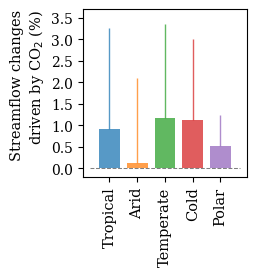

In [5]:
def Figure_1f():
    data = xr.open_dataset(r"dataset\streamflow_CO2_tend.nc")
    data2 = xr.open_dataset(r"dataset\streamflow_simulation.nc")
    con = xr.open_dataset(r"D:\Data\Beck_KG_V1\Beck_KG_5_classifications.nc")
    con = con.data[:]
    co2 = data.CO2.data[:]*40
    s3 = data2.S3.data[:]
    d = cal_area()
    lat_runoff = np.zeros((14, 5))
    for i in range(14):
        d_here = co2[i, :] * d / 1000000
        ds3_here =s3[i, :] * d / 1000000
        for j in range(5):
            lat_runoff[i, j] = np.nansum(d_here[con==j+1])/np.nansum(ds3_here[con==j+1])
    fig = plt.figure(figsize=(2.5, 2.6))
    ax = fig.add_subplot(111)
    ax.plot([0.3, 5.7], [0, 0], 'k--', zorder=0, alpha=0.5, linewidth=0.75)
    ax.plot([-10, -10], [0, 0], 'k-', zorder=0, alpha=1, linewidth=0.75, label='1 std')
    plt.bar(x=[1, 2, 3, 4, 5], height=np.median(lat_runoff, axis=0), width=0.75, alpha=0.75,
            color=['#1f77b4', '#ff7f0e', '#2ca02c', '#d62728', '#9467bd'],
            error_kw={'linewidth': 0.75})
    y = np.median(lat_runoff, axis=0)
    std = np.std(lat_runoff, axis=0)
    color = ['#1f77b4', '#ff7f0e', '#2ca02c', '#d62728', '#9467bd']
    for i in [0, 1, 2, 3, 4]:
        ax.errorbar(x=[i+1], y=y[i], yerr=[[0], [std[i]]], color=color[i], linewidth=1, alpha=0.75)

    plt.xlim([0.05, 5.95])
    plt.ylim([-0.002, 0.037])
    plt.xticks([1, 2, 3, 4, 5], ['Tropical', 'Arid', 'Temperate', 'Cold', 'Polar'],
               rotation=90,
               family='serif', fontsize=10.5)
    plt.yticks([0, 0.005, 0.01, 0.015, 0.02, 0.025, 0.03, 0.035], [0.0, 0.5, 1.0, 1.5, 2.0, 2.5, 3.0, 3.5], family='serif')
    plt.ylabel('Streamflow changes\ndriven by CO$_2$ (%)', family='serif',
               fontsize=10.5, loc='top')
    fig.patch.set_alpha(0)
    plt.tight_layout()
    plt.subplots_adjust(
        top=0.995,
        bottom=0.35,
        left=0.335,
        right=0.99,
        hspace=0.2,
        wspace=0.2)
    plt.rcParams['savefig.dpi'] = 3000
    plt.show()

Figure_1f()
